In [1]:
from glob import glob
import os
import time

import albumentations as A
import cv2
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage.morphology import binary_dilation
import segmentation_models_pytorch as smp
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from tqdm import tqdm
from PIL import Image

In [2]:
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")

In [3]:
model = smp.FPN(
    encoder_name="efficientnet-b7",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1,
    activation='sigmoid',
)
model.to(device)

FPN(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      1, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          64, 16, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          16, 64, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (

In [4]:
model.load_state_dict(torch.load('model.pth'))
model.eval()

FPN(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      1, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          64, 16, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          16, 64, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (

In [5]:
class BoneAgeSegmentationDataset(Dataset):
    def __init__(self, df, transform=None, mean=0.5, std=0.25):
        super(BoneAgeSegmentationDataset, self).__init__()
        self.df = df
        self.transform = transform
        self.mean = mean
        self.std = std
        self.resize = A.Compose([
            #     A.ChannelDropout(p=0.3),
                A.Resize(height=512, width=512)
        ])
        
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx, raw=False):
        row = self.df.iloc[idx]
        img = cv2.imread(row['input'], cv2.IMREAD_UNCHANGED)
        resized = self.resize(image=img)
        img = resized['image']
        
        if raw:
            return img
        
        if self.transform:
#             img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
            augmented = self.transform(image=img)
            img = augmented['image']
        
        img = T.functional.to_tensor(img)
        return img

In [11]:
inputs = sorted(os.listdir('../processed-dataset/'))

df = pd.DataFrame({'input': inputs}, columns=["input"])
df.input = '../processed-dataset/' + df.input

In [12]:
dataset = BoneAgeSegmentationDataset(df)

In [13]:
dataloader = DataLoader(dataset, batch_size=1)

In [15]:
!mkdir final-dataset

In [16]:
resize = A.Compose([A.Resize(height=512, width=512)])

In [18]:
files = os.listdir('../processed-dataset/')
bar = tqdm(enumerate(files), total=len(files))
for step, img_path in bar:
    image = cv2.imread('../processed-dataset/'+img_path, 0)
    resized = resize(image=image)
    img = resized['image']
    img = T.functional.to_tensor(img).to(device)
    data = img.unsqueeze(1)
    prediction = model(data).to('cpu')[0][0]
    image = data[0].to('cpu').permute(1,2,0).detach().numpy()
    image = image.reshape(512,512)
    prediction = torch.round(prediction)
    label = prediction.to('cpu').detach().numpy()

    mask = np.where(label==0, 0, image)
    img = Image.fromarray(mask*255)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img.save(f'final-dataset/{img_path}')
#     cv2.imwrite(f'segmented-dataset/{img_path}',bgr)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12611/12611 [31:10<00:00,  6.74it/s]


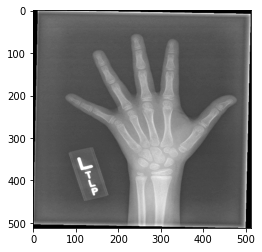

In [12]:
plt.imshow(data[0].to('cpu').permute(1,2,0), cmap='gray')

In [13]:
image = data[0].to('cpu').permute(1,2,0).detach().numpy()

In [14]:
prediction = torch.round(prediction)

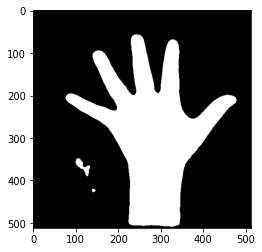

In [15]:
plt.imshow(prediction.to('cpu').detach().numpy(), cmap='gray')

In [16]:
label = prediction.to('cpu').detach().numpy()

In [17]:
image = image.reshape(512,512)

In [18]:
my_mask = np.where(label==0, 0, image)

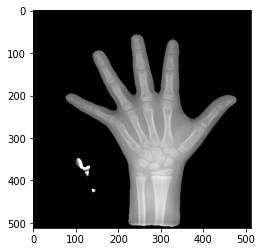

In [19]:
plt.imshow(my_mask, cmap='gray')